In [1]:
%load_ext autoreload
%autoreload 2
from new_aeb_gplvm import *
import warnings
import json
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.distributions import kl_divergence

warnings.filterwarnings("ignore")
# import the necessary package
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

2023-12-22 17:25:19.028832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 17:25:19.072219: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset_list = os.listdir("datasets/Classical")


def fix_name(name):
    fixed = name.replace(".npz", "")
    return fixed


datasets = list(map(fix_name, dataset_list))

In [3]:
df_hyper = pd.read_json("experiments/complete/gplvm/000_gplvm_normal_03_best.json")

In [4]:
def get_hypers(dataset):
    hypers = df_hyper[df_hyper.dataset == dataset]
    hp = hypers[
        [
            "kernel",
            "batch_size",
            "learning_rate",
            "latent_dim",
            "layers",
            "n_inducing",
            "n_epochs",
        ]
    ].to_dict(orient="records")
    return hp[0]

In [5]:
from baseline.PyOD import PYOD

model_dict = {"GPLVM": AD_GPLVM}

In [6]:
# datasets_ruins = [
#    "22_magic.gamma",
#    "33_skin",
# ]
# datasets_medianos = [
#    "41_Waveform",
#    "36_speech",
# ]
# datasets_bons = [
#    "16_http",
#    "21_Lymphography",
# ]
# datasets = datasets_ruins + datasets_medianos + datasets_bons

In [422]:
# seed for reproducible results
dataset = datasets[4]
seed = 42
df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
# import the dataset
datagenerator.dataset = dataset  # specify the dataset name
data = datagenerator.generator(
    la=1.00,
    realistic_synthetic_mode=None,
    noise_type=None,
    stdscale=True,
    minmax=False,
)
ratio = data["y_train"].sum() / len(data["y_train"])
Y_train, Y_test, lb_train, lb_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)
hp = get_hypers(dataset)
dataset, ratio

subsampling for dataset 05_campaign...


('05_campaign', 0.11028571428571429)

In [423]:
clf = AD_GPLVM(
    latent_dim=hp["latent_dim"],
    n_inducing=hp["n_inducing"],
    n_epochs=150,  # hp["n_epochs"],
    nn_layers=tuple(map(int, hp["layers"].split(","))),
    lr=0.01,  # hp["learning_rate"],
    batch_size=128,  # hp["batch_size"],
    kernel=hp["kernel"],
)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

In [424]:
aucroc = []
for i in range(1):
    clf.fit(Y_train, lb_train, loss_type="soft", tune="start")
    score = clf.predict_score(Y_test)
    result = utils.metric(y_true=lb_test, y_score=score)
    aucroc.append(result["aucroc"])
print(np.mean(aucroc))

0.7211578841323509


In [425]:
# loss_n = clf.loss_n
# torch.topk(
#    loss_n,
#    k=10,
#    largest = True
# )

In [426]:
# loss_a = clf.loss_a
# torch.topk(
#    loss_a,
#    k=10,
#    largest = True
# )

In [427]:
# ELBO_max = loss_n.max().item()
# ELBO_min = loss_n.min().item()
# new_ln = (loss_n - ELBO_min)/(ELBO_max - ELBO_min)

In [428]:
# torch.topk(new_ln,10, largest = True)

In [429]:
# torch.topk(-torch.log(1 + torch.exp(torch.tensor(1)) - torch.exp(new_ln)), 10)

In [430]:
# new_ln.sum().item()

In [431]:
# torch.exp(torch.tensor(1))

In [432]:
# clf.ELBO_min

In [433]:
# L_n = - (ELBO - ELBO_min)/(ELBO_max - ELBO_min)
# L_a = - log(delta + exp(1) - exp(-L_n)); delta = 1?
# ELBO_min = estimação do menor valor do ELBO
# ELBO_max = estimação do maior valor do ELBO

In [434]:
# clf.lll.sum(), clf.klu.sum(), clf.klx.sum()

In [435]:
# elbo = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [436]:
# elbo(clf.pred, clf.batch)[0].sum(),elbo(clf.pred, clf.batch)[1].sum(), elbo(clf.pred, clf.batch)[3].sum()

In [437]:
# clf.klx_loe

In [438]:
# -torch.log(1 + torch.exp(torch.max(clf.loss_n)).item() - torch.exp(clf.loss_n))

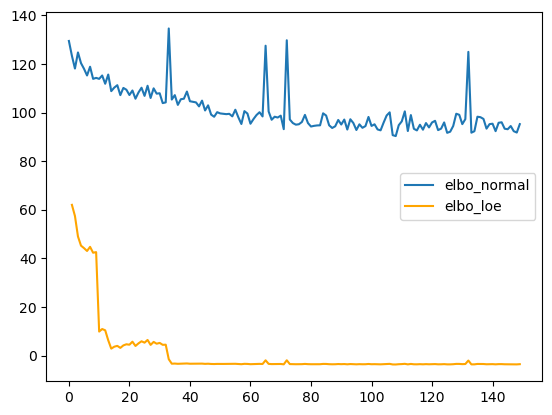

In [439]:
# plt.plot(
#   clf.lll_loe,
#   label="LL_Loe",
# )
# plt.plot(
#  clf.lll_elbo,
#  label="LL_Elbo",
# )
# plt.plot(
#    clf.klx_loe,
#    label="KLX_Loe",
# )
# plt.plot(
#   clf.klx_elbo,
#   label="KLX_Elbo",
# )
# plt.plot(
#   clf.klu_loe,
#   label="KLU_Loe",
# )
# plt.plot(
#   clf.klu_elbo,
#   label="KLU_Elbo",
# )
plt.plot(
    clf.loss_list,
    label="elbo_normal",
)
plt.plot(clf.loe_list, label="elbo_loe", color="orange")
# plt.xticks(ticks = [0,20,40,60,80], labels = [66, 86, 106,126, 146])

# plt.plot(
#    clf.norm_la,
#   label="minmax_elbo_anomaly",
# )
# plt.plot(
#    clf.norm_ln,
#    label="minmax_elbo_normal",
# )
plt.legend()
None

In [440]:
kl_divergence(clf.encoder.kl_latent.q_x, clf.encoder.kl_latent.p_x).sum(axis=0) / (
    clf.encoder.kl_latent.n
)

tensor(1.7271)

In [498]:
Y_train = torch.tensor(Y_train, dtype=torch.float32)
sample = clf.model.sample_latent_variable(Y_train)
output = clf.model(sample)

In [123]:
clf.elbo(output, Y_train.T).sum()

tensor(-42.5673, grad_fn=<SumBackward0>)

In [124]:
elbo_x = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [125]:
ll, klu, _, klx = elbo_x(output, Y_train.T)
{
    "log_likelihood": ll,
    "ll_sum": ll.sum(),
    "klx": klx,
    "klx_sum": klx.sum(),
    "klu": klu,
    "klu_sum": klu.sum(),
    "total_sum": ll.sum() - klx.sum() - klu.sum(),
}

{'log_likelihood': tensor([-1.5695, -1.5708, -1.5703, -1.5700, -1.5688, -1.5696, -1.5694, -1.5694,
         -1.5697, -1.5705, -1.5697, -1.5696, -1.5700, -1.5695, -1.5694, -1.5696,
         -1.5691, -1.5698, -1.5701, -1.5699, -1.5698, -1.5706, -1.5703, -1.5698,
         -1.5695, -1.5698, -1.5698], grad_fn=<DivBackward0>),
 'll_sum': tensor(-42.3843, grad_fn=<SumBackward0>),
 'klx': tensor([0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
        grad_fn=<AddBackward0>),
 'klx_sum': tensor(0.1080, grad_fn=<SumBackward0>),
 'klu': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'kl

In [127]:
log_likelihood = (
    clf.likelihood.expected_log_prob(Y_train.T, output).sum(0).div(len(Y_train))
)
{
    "log_likelihood": log_likelihood,
    "log_likelihood_sum": log_likelihood.sum(),
}

{'log_likelihood': tensor([-0.0045, -0.0045, -0.0048,  ..., -0.0044, -0.0042, -0.0050],
        grad_fn=<DivBackward0>),
 'log_likelihood_sum': tensor(-42.3843, grad_fn=<SumBackward0>)}

In [128]:
klu_expanded = clf.model.variational_strategy.kl_divergence().div(len(Y_train))
{
    "klu_expanded": klu_expanded,
    "klu_expanded_sum": klu_expanded.sum(),
}

{'klu_expanded': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'klu_expanded_sum': tensor(0.0750, grad_fn=<SumBackward0>)}

In [45]:
klu_zero = torch.zeros_like(Y_train)
klu_zero

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
added_loss = torch.zeros_like(log_likelihood)
for added_loss_term in clf.model.added_loss_terms():
    added_loss.add_(added_loss_term.loss())
added_loss.sum()

tensor(26.7473, grad_fn=<SumBackward0>)

In [ ]:
contamination = lb_train.sum() / len(lb_train)